# Wind Climatology Maps

In [4]:
import errno
import numpy as np
import os
import time
import xarray as xr
from datetime import datetime, timedelta
from dateutil.parser import parse
from salishsea_tools import utilities
from salishsea_tools import viz_tools
import time
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

### Decorator for timing function calls

In [5]:
def timer(func):
    """Decorator function for timing function calls
    """
    def f(*args, **kwargs):
        beganat = time.time()
        rv = func(*args, *kwargs)
        elapsed = time.time() - beganat
        hours = int(elapsed / 3600)
        mins = int((elapsed - (hours*3600))/60)
        secs = int((elapsed - (hours*3600) - (mins*60)))
        print('\nTime elapsed: {}:{}:{}\n'.format(hours, mins, secs))
        return rv
    return f

### Function for generating list of HRDPS files from input time range

In [6]:
def hrdps_paths(timestart, timeend, path='/results/forcing/atmospheric/GEM2.5/operational/'):
    """Generate wind input file paths

    :arg timestart: date from when to start concatenating
    :type string: :py:class:'str'

    :arg timeend: date at which to stop concatenating
    :type string: :py:class:'str'

    :arg path: path of input files
    :type string: :py:class:'str'

    :arg outpath: path for output files
    :type string: :py:class:'str'

    :arg compression_level: compression level for output file (Integer[1,9])
    :type integer: :py:class:'int'

    :returns tuple: tuple containing the arguments to pass to hdf5 file generator function
    :rtype: :py:class:`tuple'
    """
    
    # generate list of dates from daterange given
    daterange = [parse(t) for t in [timestart, timeend]]

    # append all filename strings within daterange to list
    wind_files = []
    for day in range(np.diff(daterange)[0].days):
        datestamp = daterange[0] + timedelta(days=day)
        
        month = datestamp.month
        if month < 10:
            month = f'0{str(month)}'
        
        day = datestamp.day
        if day < 10:
            day = f'0{str(day)}'
        
        year = str(datestamp.year)

        # check if file exists. exit if it does not. add path to list if it does.
        wind_path = f'{path}ops_y{year}m{month}d{day}.nc'
        if not os.path.exists(wind_path):
            print(f'File {wind_path} not found. Check Directory and/or Date Range.')
            return 
        wind_files.append(wind_path)
        
    return wind_files

### Create a mask

In [ ]:
# build the land mask for the GEM grid. I have saved this as a pickle file /ocean/abhudia/MEOPAR/analysis-ashutosh/GEM_mask.pickle so no need to recompute.
def build_GEM_mask(grid_GEM, grid_NEMO, mask_NEMO):
    # Preallocate
    ngrid_GEM = grid_GEM['gridX'].shape[0] * grid_GEM['gridY'].shape[0]
    mask_GEM = np.zeros(ngrid_GEM, dtype=int)

    # Evaluate each point on GEM grid
    bar = utilities.statusbar('Building GEM mask', width=90, maxval=ngrid_GEM)
    for index, coords in enumerate(bar(zip(
            grid_GEM['longitude'].values.reshape(ngrid_GEM) - 360,
            grid_GEM['latitude'].values.reshape(ngrid_GEM),
    ))):

        j, i = geo_tools.find_closest_model_point(
            coords[0], coords[1],
            grid_NEMO['longitude'], grid_NEMO['latitude'],
        )
        if j is np.nan or i is np.nan:
            mask_GEM[index] = 0
        else:
            mask_GEM[index] = mask_NEMO[j, i].values

    # Reshape
    mask_GEM = mask_GEM.reshape(grid_GEM['longitude'].shape)
    mask_GEM = np.select([mask_gem == 0, mask_gem == 1], [np.nan, 1])
    return mask_GEM

# save this is a pickle so that you don't have to recompute this
land_mask = build_GEM_mask(GEM, nemo_grid, nemo_mask.tmaskutil.isel(time=0))
picklemask = open('GEM_mask.pickle', 'wb')
pickle.dump(land_mask, picklemask)

### Load mask from memory

In [8]:
# Loading land mask from file
openpickle = open("GEM_mask.pickle" , 'rb') 
land_mask = pickle.load(openpickle)
land_mask = np.select([land_mask == 0, land_mask == 1], [np.nan, 1])

### Function for generating netcdf file of wind speeds

In [9]:
@timer
def generate_netcdf(begin, end, outfile, land_mask):
    """
    :arg begin: date from when to start generating wind speed
    :type string: :py:class:'str'

    :arg end: date at which to stop generating wind speed
    :type string: :py:class:'str'

    :arg outfile: path of output files
    :type string: :py:class:'str'
    """
    # prevent accidental overwriting
    if os.path.exists(outfile):
        print(f'{outfile} already exists')
        return
    # Get a list of the HRDPS files to loop through
    wind_files = hrdps_paths(begin, end)
    
    # loop thorugh files, calculating the maginutde of the wind speed
    bar = utilities.statusbar('Loading...', maxval=len(wind_files))
    for i, file in bar(enumerate(wind_files)):
        file = xr.open_dataset(file)
        GEM_u, GEM_v = file.u_wind*land_mask,file.v_wind*land_mask
        # for the fist loop, create GEM_mags object
        if i == 0:
            GEM_mags = xr.ufuncs.sqrt(xr.ufuncs.square(GEM_u) + xr.ufuncs.square(GEM_v))
        # for the rest of the loops, concatenate the GEM_mags with the magnitude of the current loop 
        else:
            GEM_mag = xr.ufuncs.sqrt(xr.ufuncs.square(GEM_u) + xr.ufuncs.square(GEM_v))
            GEM_mags = xr.concat((GEM_mags,GEM_mag),dim = 'time_counter')
    # Create a dataset, write maximum and minimum values to attrs metadata and save as .nc
    GEM_mags = GEM_mags.to_dataset(name='wind_speed')
    GEM_mags.attrs['maximum'] = float(GEM_mags.wind_speed.max())
    GEM_mags.attrs['minimum'] = float(GEM_mags.wind_speed.min())
    GEM_mags.to_netcdf(outfile)

### Generating the wind speeds for a year takes about five minutes on Hake, not bad. I've done 2015, 2016 here so I can loop through them later when normalising plots

In [7]:
generate_netcdf('1 jan 2015', '1 jan 2016', 'MIDOSS/2015_windspeed.nc', land_mask)

Loading... 100% (365 of 365) |##################################|Time:  0:03:15



Time elapsed: 0:4:0



In [8]:
generate_netcdf('1 jan 2016', '1 jan 2017', 'MIDOSS/2016_windspeed.nc', land_mask)

Loading... 100% (366 of 366) |##################################|Time:  0:05:07



Time elapsed: 0:5:52



In [ ]:
generate_netcdf('1 jan 2017', '1 jan 2018', 'MIDOSS/2017_windspeed.nc', land_mask)

Loading...  22% (81 of 365) |#######                            |ETA:   0:02:33

In [ ]:
generate_netcdf('1 jan 2018', '1 jan 2019', 'MIDOSS/2018_windspeed.nc', land_mask)

### Get the bounds for slicing the uneeded areas out of the land mask

In [226]:
def slice_bounds(a = land_mask):
    yshape, xshape = land_mask.shape
    check = False
    for yind in range(yshape):
        if check is False:
            if not np.isnan(a[yind]).all():
                ymin = yind
                check = True
        if check is True:
            if np.isnan(a[yind]).all():
                ymax = yind+1
                check = False
                break
    for xind in range(xshape):
        if check is False:
            if not np.isnan(a[...,xind]).all():
                xmin = xind
                check = True
        if check is True:
            if np.isnan(a[...,xind]).all():
                xmax = xind+1
                break
    return ymin, ymax, xmin, xmax

### Loop through .nc files

In [227]:
paths = ['MIDOSS/2015_windspeed.nc', 'MIDOSS/2016_windspeed.nc', 'MIDOSS/2017_windspeed.nc', 'MIDOSS/2018_windspeed.nc']
xr_files = []
for path in paths:
    xr_files.append(xr.open_dataset(path))

In [228]:
def find_limits(xr_array, minval, maxval):
    if minval is None:
        minval, maxval = float(xr_array.min()), float(xr_array.max())
        return minval, maxval
    else:
        cmin, cmax = float(xr_array.min()), float(xr_array.max())
        if cmin < minval:
            minval = cmin
        if cmax > maxval:
            maxval = cmax
        return minval, maxval

In [229]:
months = ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December')
thresholds = (5,10)
all_dict = {} # dict for storing all the years' data
mean_minval, mean_maxval, std_minval, std_maxval, max_minval, max_maxval = None, None, None, None, None, None

for threshold in thresholds:
    locals()[f't_{threshold}_minval'], locals()[f't_{threshold}_maxval'] = None, None

# get the monthly stats for each year
for index, xr_file in enumerate(xr_files):
    mean_dict, std_dict, max_dict = {},{},{}
    for threshold in thresholds:
        locals()[f't_{threshold}'] = {}
    for i, month in enumerate(months):
        time_slice = xr_file.wind_speed.loc[xr_file.time_counter['time_counter.month'].isin([i+1])] * land_mask
        # ----- % > threshold limit----- #
        # fore each of the thresholds, find the percentage exceeding it
        for threshold in thresholds:
            condlist = [time_slice >= threshold, time_slice < threshold]
            choicelist = [1,0]
            exceed_threshold_percent = np.sum(np.select(condlist, choicelist), axis = 0) / time_slice.shape[0] * 100
            # find the limits, using local variable call
            locals()[f't_{threshold}_minval'], locals()[f't_{threshold}_maxval']  = find_limits(
                exceed_threshold_percent,
                locals()[f't_{threshold}_minval'],
                locals()[f't_{threshold}_maxval']
            )
        # update the dict with the monthly data
        locals()[f't_{threshold}'][month] = exceed_threshold_percent
        # ----- mean ---- #
        mean = time_slice.mean(dim = 'time_counter') 
        mean_minval, mean_maxval = find_limits(mean, mean_minval, mean_maxval)
        mean_dict[month] = mean
        
        # ---- standard deviation ---- #
        stddev = time_slice.std(dim = 'time_counter') 
        std_minval, std_maxval = find_limits(stddev, std_minval, std_maxval)
        std_dict[month] = stddev
        
        # ---- maxima ---- #
        maxima = time_slice.max(dim = 'time_counter') 
        max_minval, max_maxval = find_limits(maxima, max_minval, max_maxval)
        max_dict[month] = maxima
        
        

    all_dict[paths[index]] = {'mean' : mean_dict, 'std_dev' : std_dict, 'maxima' : max_dict}
    
    # for each of the thresholds, add to the dict
    for threshold in thresholds:
        all_dict[paths[index]][f't_{threshold}'] = locals()[f't_{threshold}']
        
# Get the monthly stats for the entire record
mean_dict, std_dict, max_dict = {},{},{}
for threshold in thresholds:
    locals()[f't_{threshold}'] = {}
for month_index, month in enumerate(months):
    check = False
    for xr_file in xr_files:
        current_time_slice = xr_file.wind_speed.loc[xr_file.time_counter['time_counter.month'].isin([i+1])] * land_mask
        if check is False:
            time_slice = current_time_slice 
            check = True
        else:
            time_slice = xr.concat((time_slice, current_time_slice), dim = 'time_counter') 

    # ----- % > threshold limit----- #
    for threshold in thresholds:
        condlist = [time_slice >= threshold, time_slice < threshold]
        choicelist = [1,0]
        exceed_threshold_percent = np.sum(np.select(condlist, choicelist), axis = 0) / time_slice.shape[0] * 100
        # find the limits, using local variable call
        locals()[f't_{threshold}_minval'], locals()[f't_{threshold}_maxval']  = find_limits(
            exceed_threshold_percent,
            locals()[f't_{threshold}_minval'],
            locals()[f't_{threshold}_maxval']
        )
    # update the dict with the monthly data
    locals()[f't_{threshold}'][month] = exceed_threshold_percent
    # ----- mean ---- #
    mean = time_slice.mean(dim = 'time_counter') 
    mean_minval, mean_maxval = find_limits(mean, mean_minval, mean_maxval)
    mean_dict[month] = mean

    # ---- standard deviation ---- #
    stddev = time_slice.std(dim = 'time_counter') 
    std_minval, std_maxval = find_limits(stddev, std_minval, std_maxval)
    std_dict[month] = stddev

    # ---- maxima ---- #
    maxima = time_slice.max(dim = 'time_counter') 
    max_minval, max_maxval = find_limits(maxima, max_minval, max_maxval)
    max_dict[month] = maxima

    all_dict['full_record'] = {'mean' : mean_dict, 'std_dev' : std_dict, 'maxima' : max_dict}
    
    # for each of the thresholds, add to the dict
    for threshold in thresholds:
        all_dict['full_record'][f't_{threshold}'] = locals()[f't_{threshold}']

# add the overall limits founds to a dict for normalisation
limits = {'mean_minval':mean_minval, 'mean_maxval':mean_maxval,
          'std_minval':std_minval, 'std_maxval':std_maxval,
          'max_minval':max_minval, 'max_maxval':max_maxval}
# add the threshold limits as well                                        
for threshold in thresholds:
    limits[f't_{threshold}_minval'] = locals()[f't_{threshold}_minval']
    limits[f't_{threshold}_maxval'] = locals()[f't_{threshold}_maxval']
# finally, ad these limits to the outpout dict
all_dict['bounds'] = limits

/home/abhudia/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [232]:
# store this as a pickle, nothing will change if you recompute it
with open('wind_analysis.pickle', 'wb') as pf:
    pickle.dump(all_dict, pf)

In [233]:
# how to lead the pickle
with open('wind_analysis.pickle', 'rb') as pf:
    all_dict = pickle.load(pf)

In [234]:
all_dict['bounds']

{'mean_minval': 0.7626684523640112,
 'mean_maxval': 9.33437252997316,
 'std_minval': 0.3110236143172253,
 'std_maxval': 5.073798101010036,
 'max_minval': 2.289755489638702,
 'max_maxval': 24.005032604142023,
 't_5_minval': 0.0,
 't_5_maxval': 91.93548387096774,
 't_10_minval': 0.0,
 't_10_maxval': 42.33870967741936}

In [235]:
all_dict.keys()

dict_keys(['MIDOSS/2015_windspeed.nc', 'MIDOSS/2016_windspeed.nc', 'MIDOSS/2017_windspeed.nc', 'MIDOSS/2018_windspeed.nc', 'full_record', 'bounds'])

/home/abhudia/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


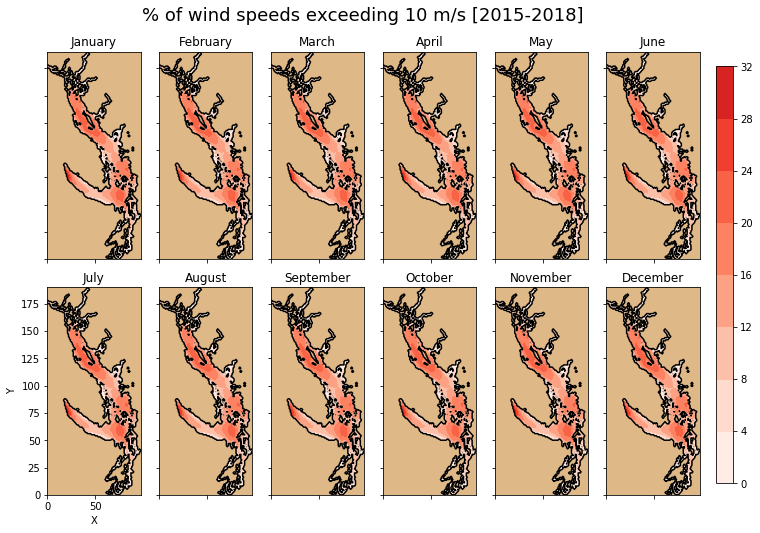

In [236]:
fig = plt.figure()
fig.set_size_inches(11.69, 8.27)
minval, maxval = all_dict['bounds']['t_10_minval'], all_dict['bounds']['t_10_maxval']
contour_mask = np.select([np.isnan(land_mask), ~np.isnan(land_mask)], [0,1])[ymin:ymax, xmin:xmax]
for i, key in enumerate(all_dict['full_record']['t_10'].keys()):
    ax = plt.subplot(2,6,i+1)
    wind_plot = plt.contourf(all_dict['full_record']['t_10'][key][ymin:ymax, xmin:xmax], vmin = minval, vmax = maxval, cmap = 'Reds')
    plt.contourf(contour_mask, colors='Burlywood', levels = [-0.01,0.01])
    plt.contour(contour_mask, colors ='k', levels = [-0.01,0.01])
    viz_tools.set_aspect(ax)
    plt.title(key)
    if i is not 6:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    if i == 6:
        plt.xlabel('X')
        plt.ylabel('Y')

# adjust and save plots as .pdf
plt.subplots_adjust(hspace=0.1)
figtitle = '% of wind speeds exceeding 10 m/s [2015-2018]'
fig.suptitle(figtitle, fontsize  =  18, y=0.95)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(wind_plot, cax=cbar_ax, extend='both')

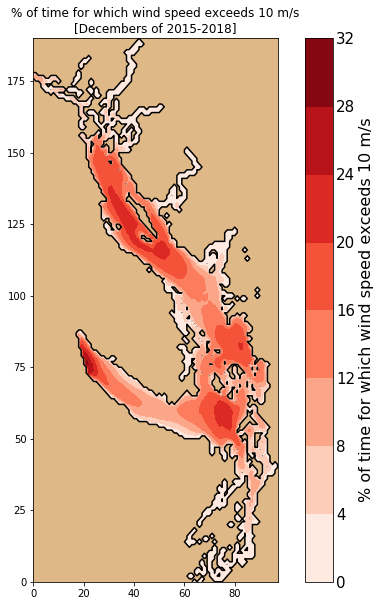

In [237]:
# plot a single month from the entire record
ymin, ymax, xmin, xmax = slice_bounds()
contour_mask = np.select([np.isnan(land_mask), ~np.isnan(land_mask)], [0,1])[ymin:ymax, xmin:xmax]
array = all_dict['full_record']['t_10']['December']
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
wind_plot = plt.contourf(array[ymin:ymax, xmin:xmax],cmap= 'Reds')
cbar = plt.colorbar(extend = 'both')
plt.contourf(contour_mask, colors='Burlywood', levels = [-0.01,0.01])
plt.contour(contour_mask, colors ='k', levels = [-0.01,0.01])
viz_tools.set_aspect(ax)
cbar.set_label('% of time for which wind speed exceeds 10 m/s', fontsize=16)
cbar.ax.tick_params(axis='y', length=0, labelsize=15)
plt.title('% of time for which wind speed exceeds 10 m/s\n[Decembers of 2015-2018]')
plt.savefig('10msDecembernew.png', dpi = 200)